In [1]:
import pandas as pd
import utils
import seaborn as sns
import matplotlib.pyplot as plt
import random
import plotly.express as px

random.seed(9000)

plt.style.use("seaborn-ticks")
plt.rcParams["image.cmap"] = "Set1"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
%matplotlib inline

In this notebook, we calculate the `Percent Matching` score between chemical and genetic perturbations.

In [2]:
corr_df = pd.DataFrame()
n_samples = 1000

compound_experiments = {
    'A549':{'24':{'BR00116991':'A549 24-hour Compound Plate 1',
                  'BR00116992':'A549 24-hour Compound Plate 2',
                  'BR00116993':'A549 24-hour Compound Plate 3',
                  'BR00116994':'A549 24-hour Compound Plate 4'
                },
            '48':{'BR00117017':'A549 48-hour Compound Plate 1',
                  'BR00117019':'A549 48-hour Compound Plate 2',
                  'BR00117015':'A549 48-hour Compound Plate 3',
                  'BR00117016':'A549 48-hour Compound Plate 4'
                  }
            },
    'U2OS':{'24':{'BR00116995':'U2OS 24-hour Compound Plate 1',
                  'BR00117024':'U2OS 24-hour Compound Plate 2',
                  'BR00117025':'U2OS 24-hour Compound Plate 3',
                  'BR00117026':'U2OS 24-hour Compound Plate 4'
                  },
            '48':{'BR00117012':'U2OS 48-hour Compound Plate 1',
                  'BR00117013':'U2OS 48-hour Compound Plate 2',
                  'BR00117010':'U2OS 48-hour Compound Plate 3',
                  'BR00117011':'U2OS 48-hour Compound Plate 4'
                  }
            }
}

orf_experiments = {
    'A549':{'48':{'BR00117020':'A549 48-hour ORF Plate 1',
                  'BR00117021':'A549 48-hour ORF Plate 2'
                  },
            '96':{'BR00118050':'A549 96-hour ORF Plate 1',
                  'BR00117006':'A549 96-hour ORF Plate 2'
                }
            },
    'U2OS':{'48':{'BR00117022':'U2OS 48-hour ORF Plate 1',
                  'BR00117023':'U2OS 48-hour ORF Plate 2'
                  },
            '96':{'BR00118039':'U2OS 96-hour ORF Plate 1',
                  'BR00118040':'U2OS 96-hour ORF Plate 2'
                  }
            }
}

crispr_experiments = {
    'A549':{'96':{'BR00118041':'A549 96-hour CRISPR Plate 1',
                  'BR00118042':'A549 96-hour CRISPR Plate 2',
                  'BR00118043':'A549 96-hour CRISPR Plate 3',
                  'BR00118044':'A549 96-hour CRISPR Plate 4'
                  },
            '144':{'BR00117003':'A549 144-hour CRISPR Plate 1',
                   'BR00117004':'A549 144-hour CRISPR Plate 2',
                   'BR00117005':'A549 144-hour CRISPR Plate 3',
                   'BR00117000':'A549 144-hour CRISPR Plate 4'
                   }
            },
    'U2OS':{'96':{'BR00118045':'U2OS 96-hour CRISPR Plate 1',
                  'BR00118046':'U2OS 96-hour CRISPR Plate 2',
                  'BR00118047':'U2OS 96-hour CRISPR Plate 3',
                  'BR00118048':'U2OS 96-hour CRISPR Plate 4'
                  },
            '144':{'BR00116997':'U2OS 144-hour CRISPR Plate 1',
                   'BR00116998':'U2OS 144-hour CRISPR Plate 2',
                   'BR00116999':'U2OS 144-hour CRISPR Plate 3',
                   'BR00116996':'U2OS 144-hour CRISPR Plate 4'
                   }
            }
}

experiment_name = "2020_11_04_CPJUMP1"

In [3]:
for compound_cell in compound_experiments:
    for compound_time in compound_experiments[compound_cell]:
        compound_df = pd.DataFrame()
        for plate in compound_experiments[compound_cell][compound_time]:
            data_df = (
                utils.load_data(experiment_name, plate, "normalized_feature_select_negcon_plate.csv.gz")
                .rename(columns={'Metadata_target':'Metadata_gene'})
                .assign(Metadata_modality='Compound')
                .assign(Metadata_cell_id=compound_cell)
                .assign(Metadata_time_point=compound_time)
                .assign(Metadata_experiment=f'Compound_{compound_cell}_{compound_time}')
            )
            compound_df = utils.concat_profiles(compound_df, data_df)

        compound_df = utils.remove_negcon_empty_wells(compound_df)

        for orf_cell in orf_experiments:
            if compound_cell == orf_cell:
                for orf_time in orf_experiments[orf_cell]:
                    orf_df = pd.DataFrame()
                    for plate in orf_experiments[orf_cell][orf_time]:
                        data_df = (
                            utils.load_data(experiment_name, plate, "normalized_feature_select_negcon_plate.csv.gz")
                            .assign(Metadata_modality='ORF')
                            .assign(Metadata_cell_id=orf_cell)
                            .assign(Metadata_time_point=orf_time)
                            .assign(Metadata_experiment=f'ORF_{orf_cell}_{orf_time}')
                        )
                        orf_df = utils.concat_profiles(orf_df, data_df)

                    orf_df = utils.remove_negcon_empty_wells(orf_df)

                    signal = utils.correlation_between_modalities(compound_df, orf_df, 'Compound', 'ORF','Metadata_gene', 'Metadata_broad_sample')
                    null = utils.null_correlation_between_modalities(compound_df, orf_df, 'Compound', 'ORF','Metadata_gene', 'Metadata_broad_sample', n_samples)

                    prop_5_95, value_95 = utils.percent_score(null, signal, how='right')

                    corr_df = corr_df.append({'Experiment':f'Compound_{compound_cell}_{compound_time} vs. ORF_{orf_cell}_{orf_time}',
                                              'Signal':signal,
                                              'Null':null,
                                              'Percent_Matching':'%.3f'%prop_5_95,
                                              'Value_95':value_95}, ignore_index=True)

        for crispr_cell in crispr_experiments:
            if compound_cell == crispr_cell:
                for crispr_time in crispr_experiments[crispr_cell]:
                    crispr_df = pd.DataFrame()
                    for plate in crispr_experiments[crispr_cell][crispr_time]:
                        data_df = (
                            utils.load_data(experiment_name, plate, "normalized_feature_select_negcon_plate.csv.gz")
                                .assign(Metadata_modality='CRISPR')
                                .assign(Metadata_cell_id=orf_cell)
                                .assign(Metadata_time_point=orf_time)
                                .assign(Metadata_experiment=f'CRISPR_{orf_cell}_{orf_time}')
                            )
                        crispr_df = utils.concat_profiles(crispr_df, data_df)

                    crispr_df = utils.remove_negcon_empty_wells(crispr_df)

                    signal = utils.correlation_between_modalities(compound_df, crispr_df, 'Compound', 'CRISPR','Metadata_gene', 'Metadata_broad_sample')
                    null = utils.null_correlation_between_modalities(compound_df, crispr_df, 'Compound', 'CRISPR','Metadata_gene', 'Metadata_broad_sample', n_samples)

                    prop_5_95, value_95 = utils.percent_score(null, signal, how='right')

                    corr_df = corr_df.append({'Experiment':f'Compound_{compound_cell}_{compound_time} vs. CRISPR_{crispr_cell}_{crispr_time}',
                                              'Signal':signal,
                                              'Null':null,
                                              'Percent_Matching':'%.3f'%prop_5_95,
                                              'Value_95':value_95}, ignore_index=True)

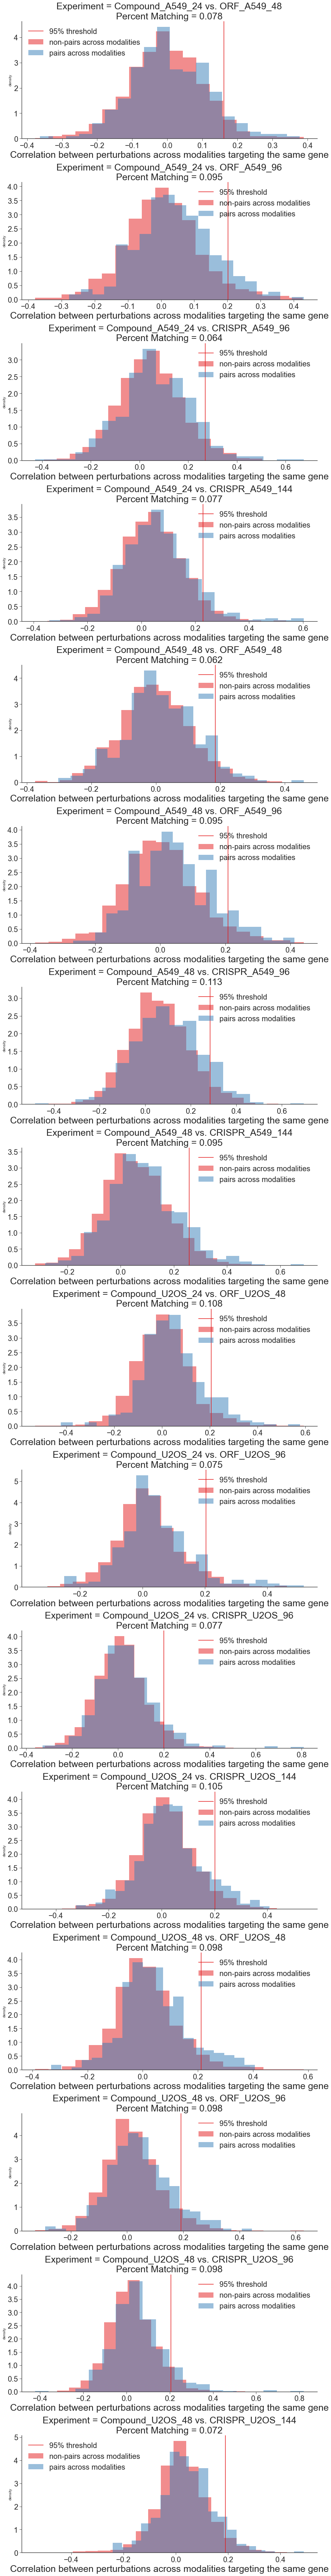

In [4]:
n_experiments = len(corr_df)

plt.rcParams['figure.facecolor'] = 'white'
plt.figure(figsize=[12, n_experiments*6])

for i in range(n_experiments):
    plt.subplot(n_experiments, 1, i+1)
    plt.hist(corr_df.loc[i,'Null'], label='non-pairs across modalities', density=True, bins=20, alpha=0.5)
    plt.hist(corr_df.loc[i,'Signal'], label='pairs across modalities', density=True, bins=20, alpha=0.5)
    plt.axvline(corr_df.loc[i,'Value_95'], label='95% threshold')
    # plt.axvline(corr_df.loc[i,'Value_5'], label='5% threshold', color='blue')
    plt.legend(fontsize=20)
    plt.title(
        f"Experiment = {corr_df.loc[i,'Experiment']}\n" +
        f"Percent Matching = {corr_df.loc[i,'Percent_Matching']}",
        fontsize=25
    )
    plt.ylabel("density")
    plt.xlabel("Correlation between perturbations across modalities targeting the same gene", fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    sns.despine()
plt.tight_layout()
plt.savefig('figures/1.percent_matching_compounds_vs_genes.png')

In [5]:
print(corr_df[['Experiment','Percent_Matching']].to_markdown(index=False))

| Experiment                           |   Percent_Matching |
|:-------------------------------------|-------------------:|
| Compound_A549_24 vs. ORF_A549_48     |              0.078 |
| Compound_A549_24 vs. ORF_A549_96     |              0.095 |
| Compound_A549_24 vs. CRISPR_A549_96  |              0.064 |
| Compound_A549_24 vs. CRISPR_A549_144 |              0.077 |
| Compound_A549_48 vs. ORF_A549_48     |              0.062 |
| Compound_A549_48 vs. ORF_A549_96     |              0.095 |
| Compound_A549_48 vs. CRISPR_A549_96  |              0.113 |
| Compound_A549_48 vs. CRISPR_A549_144 |              0.095 |
| Compound_U2OS_24 vs. ORF_U2OS_48     |              0.108 |
| Compound_U2OS_24 vs. ORF_U2OS_96     |              0.075 |
| Compound_U2OS_24 vs. CRISPR_U2OS_96  |              0.077 |
| Compound_U2OS_24 vs. CRISPR_U2OS_144 |              0.105 |
| Compound_U2OS_48 vs. ORF_U2OS_48     |              0.098 |
| Compound_U2OS_48 vs. ORF_U2OS_96     |              0.098 |
| Compou

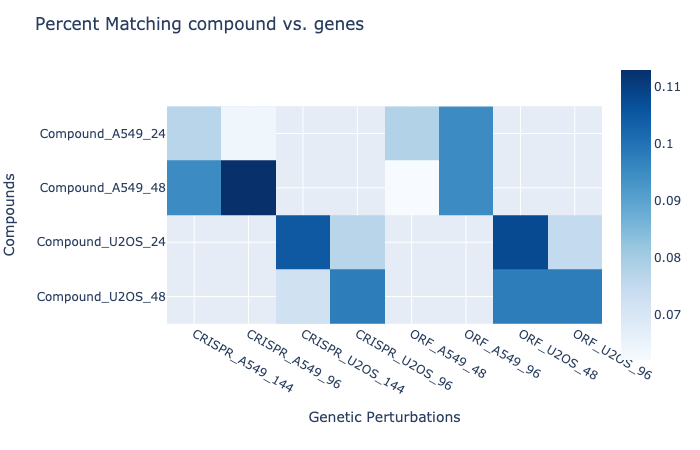

In [6]:
corr_df[['Chemical_Perturbation','Genetic_Perturbation']] = corr_df.Experiment.str.split(' vs. ', expand=True,)
corr_df['Percent_Matching'] = corr_df['Percent_Matching'].astype(float)
pivot_table = corr_df.pivot('Chemical_Perturbation','Genetic_Perturbation','Percent_Matching')
fig = px.imshow(pivot_table, color_continuous_scale='blues')
fig.update_layout(title='Percent Matching compound vs. genes',
                  xaxis=dict(title='Genetic Perturbations'),
                  yaxis=dict(title='Compounds'))
fig.show("png")
fig.write_image(f'figures/1.percent_matching_heatmap.png', width=640, height=480, scale=2)

In [7]:
print(corr_df[['Chemical_Perturbation','Genetic_Perturbation','Percent_Matching']].to_markdown(index=False))

| Chemical_Perturbation   | Genetic_Perturbation   |   Percent_Matching |
|:------------------------|:-----------------------|-------------------:|
| Compound_A549_24        | ORF_A549_48            |              0.078 |
| Compound_A549_24        | ORF_A549_96            |              0.095 |
| Compound_A549_24        | CRISPR_A549_96         |              0.064 |
| Compound_A549_24        | CRISPR_A549_144        |              0.077 |
| Compound_A549_48        | ORF_A549_48            |              0.062 |
| Compound_A549_48        | ORF_A549_96            |              0.095 |
| Compound_A549_48        | CRISPR_A549_96         |              0.113 |
| Compound_A549_48        | CRISPR_A549_144        |              0.095 |
| Compound_U2OS_24        | ORF_U2OS_48            |              0.108 |
| Compound_U2OS_24        | ORF_U2OS_96            |              0.075 |
| Compound_U2OS_24        | CRISPR_U2OS_96         |              0.077 |
| Compound_U2OS_24        | CRISPR_U2O